# Single-Atom Local Gaussian Fit
This minimal notebook builds a single-atom projected potential, places one Gaussian beam at the centre, and compares the Gaussian phase with the local potential curvature. We also show a 1D phase cross-section.

In [8]:
# Imports and config
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.1'
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from ase import Atoms
import abtem
from abtem.core.energy import energy2wavelength, energy2sigma

from temgym_core.utils import fibonacci_spiral
from temgym_core.components import Detector
from temgym_core.gaussian import GaussianRayBeta
from temgym_core.gaussian_taylor import Potential, run_to_end, evaluate_gaussian_packets_jax_scan
from skimage.restoration import unwrap_phase

jax.config.update('jax_enable_x64', True)
%matplotlib widget

In [9]:
# Build a single-atom projected potential and a Gaussian at the centre
def make_single_atom(symbol='Si', box_A=(20.0, 20.0, 20.0)):
    Lx, Ly, Lz = map(float, box_A)
    return Atoms(
        symbols=symbol,
        positions=[[Lx / 2, Ly / 2, Lz / 2]],
        cell=[Lx, Ly, Lz],
        pbc=False
    )

def projected_potential_2d(
    src,
    sampling_A=0.02,
    parametrization='lobato',
    projection='infinite',
    periodic=False,
    box_A=None,
    slice_thickness=1.0
):
    # Use abTEM to compute projected potential and return V2d with sampling/origin matching temgym Potential
    if isinstance(src, Atoms):
        pot = abtem.Potential(
            src,
            sampling=sampling_A,
            parametrization=parametrization,
            projection=projection,
            periodic=periodic,
            slice_thickness=slice_thickness,
            box=None if box_A is None else tuple(map(float, box_A))
        )
        proj = pot.project().compute()
        V2d = np.asarray(proj.array)
        sy, sx = proj.sampling
    elif hasattr(src, 'project') and hasattr(src, 'compute'):
        proj = src.project().compute()
        V2d = np.asarray(proj.array)
        sy, sx = proj.sampling
    else:
        raise TypeError('Unsupported src for projected_potential_2d')
    ny, nx = V2d.shape
    Lx, Ly = nx * sx, ny * sy
    x0, y0 = -Lx / 2.0, -Ly / 2.0
    return V2d, float(sx), float(sy), float(x0), float(y0)

In [10]:

# Parameters
accel_V = 200_000
wavelength = energy2wavelength(accel_V)
sigma = energy2sigma(accel_V)


# Single atom
Lx, Ly, Lz = 2.0, 2.0, 2.0
atoms = make_single_atom('Si', box_A=(Lx, Ly, Lz))
V2d, sx, sy, x0, y0 = projected_potential_2d(atoms, sampling_A=0.001, parametrization='lobato', projection='infinite', periodic=False, box_A=(Lx, Ly, Lz))

potential = Potential(z=0.0, V=jnp.asarray(V2d, dtype=jnp.float64), sx=sx, sy=sy, x0=x0, y0=y0, order=3)

# Build a small detector/grid for field evaluation
W = Lx  # window size in Å
Nx, Ny = V2d.shape[1], V2d.shape[0]
dx = W / Nx
dy = W / Ny
grid = Detector(z=0.0, pixel_size=(dy, dx), shape=(Ny, Nx))

extent = (x0, x0 + Nx * dx, y0, y0 + Ny * dy)

w0 = 0.01
num_rays = 1
rx, ry = fibonacci_spiral(num_rays, radius=0.5)
rx = rx + 0.1
lam = jnp.ones(num_rays) * wavelength
k0 = 2 * jnp.pi / lam
C0 = jnp.ones(num_rays) * (1.0 + 0.0j)
eta = jnp.zeros((num_rays, 2), dtype=jnp.complex128)
scale = -1j * (2.0 / (k0 * w0**2))
Qinv0 = scale[..., None, None] * jnp.eye(2, dtype=jnp.complex128)
ray_in = GaussianRayBeta(x=rx, y=ry, dx=jnp.zeros_like(rx), dy=jnp.zeros_like(ry), z=jnp.zeros_like(rx), pathlength=jnp.zeros_like(rx), Q_inv=Qinv0, eta=eta, C=C0, voltage=accel_V)
ray_in = ray_in.to_vector()

components = [potential]


[                                        ] | 0% Completed | 336.24 us

[########################################] | 100% Completed | 204.66 ms


/home/dl277493/Microscope-Calibration/TemGymCore/src/temgym_core/utils.py:310: RuntimeWarning: invalid value encountered in sqrt
  radius * np.sqrt((ii + 0.5) / (nb_samples - 0.5 * (np_boundary + 1)))


Solution with functions

In [11]:
ray_out = run_to_end(ray_in, components)
functional_field = evaluate_gaussian_packets_jax_scan(ray_out, grid, batch_size=32)

Hand coded solution

In [12]:
# Setup
r_xy = ray_in.r_xy
r2 = grid.coords
k = ray_in.k

# Complex OPL and its derivatives (thin element), scaled by 1/k because sigma * V is a phase term already, and we want it in terms of optical path length (opl) - opl = phase / k
opl = sigma * potential.V_interp(r_xy) / k
grad_opl = sigma * potential.grad_V_interp(r_xy) / k
Hess_opl = sigma * potential.hess_V_interp(r_xy) / k

# Update linear/quadratic params by subtracting thin-element Taylor terms
eta = ray_in.eta - grad_opl
Qinv = ray_in.Q_inv - Hess_opl

print(eta)
print(Qinv)
# Evaluate local quadratic
delta = r2 - r_xy
lin = jnp.sum(delta * eta, axis=-1)
quad = jnp.sum((delta @ Qinv) * delta, axis=-1)
local = k * (lin + 0.5 * quad)

phase = jnp.real(local)
logA = jnp.imag(local)
logA = jnp.clip(logA, a_min=-700.0, a_max=0.0)

# New input constant amplitude and phase
amp0 = ray_in.C * jnp.exp(1j * k * opl)

# Local linear and quadratic taylor expansions of amplitude and phase
lin_and_quad_taylor_amp_phase = jnp.exp(logA) * jnp.exp(-1j * phase)

hand_coded_field = amp0 * lin_and_quad_taylor_amp_phase
hand_coded_field = hand_coded_field.reshape(grid.shape)

[[ 9.08759255e-03+0.j -4.43903505e-08+0.j]]
[[[-2.30829822e-01-79.83001962j -2.21951752e-05 +0.j        ]
  [-2.21951752e-05 +0.j          5.77962363e-02-79.83001962j]]]


In [13]:
# 1D coords from grid
x1d, y1d = grid.coords_1d
xy_coords = grid.coords

# ray hit position
rx = float(r_xy[0, 0])
ry = float(r_xy[0, 1])

# nearest grid indices to ray hit
ix = np.argmin(np.abs(np.asarray(x1d) - rx))
iy = np.argmin(np.abs(np.asarray(y1d) - ry))

hand_coded_phase = np.angle(hand_coded_field)
hand_coded_opl = unwrap_phase(hand_coded_phase) / k
hand_coded_opl = hand_coded_opl - float(hand_coded_opl[iy, ix])

analytic_phase = np.real(ray_in.sigma * potential.V_interp(xy_coords)).reshape(grid.shape)
analytic_opl = analytic_phase / k
analytic_opl = np.asarray(analytic_opl) - float(analytic_opl[iy, ix])

functional_phase = np.angle(functional_field)
functional_opl = unwrap_phase(functional_phase) / ray_in.k
functional_opl = np.asarray(functional_opl) - float(functional_opl[iy, ix])

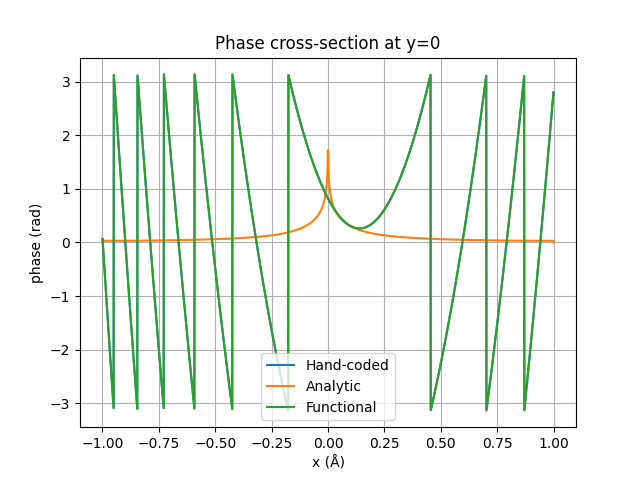

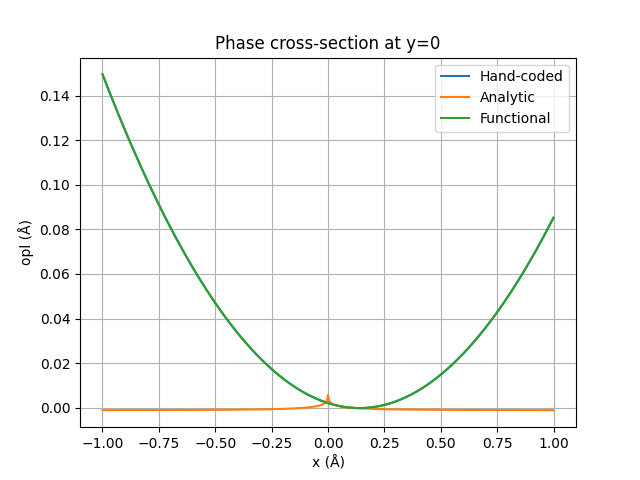

In [14]:
plt.figure()
plt.plot(x1d, hand_coded_opl[np.argmin(np.abs(y1d - 0.0)), :], label='Hand-coded')
plt.plot(x1d, analytic_opl[np.argmin(np.abs(y1d - 0.0)), :], label='Analytic')
plt.plot(x1d, functional_opl[np.argmin(np.abs(y1d - 0.0)), :], label='Functional')
plt.xlabel('x (Å)')
plt.ylabel('opl (Å)')
plt.title('Phase cross-section at y=0')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(x1d, hand_coded_phase[np.argmin(np.abs(y1d - 0.0)), :], label='Hand-coded')
plt.plot(x1d, analytic_phase[np.argmin(np.abs(y1d - 0.0)), :], label='Analytic')
plt.plot(x1d, functional_phase[np.argmin(np.abs(y1d - 0.0)), :], label='Functional')
plt.xlabel('x (Å)')
plt.ylabel('phase (rad)')
plt.title('Phase cross-section at y=0')
plt.grid(True)
plt.legend()
plt.show()
